In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from Data_extraction import Get_data
import Model
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


In [10]:
ratio_tr_te = 70
batch_size = 16

In [16]:
samples, labels = Get_data('Aigle', ['senegal', 'medi', 'us'], Normalized = True)

lookback = 90
X = np.zeros(shape=[len(samples),lookback, 8])
Y = np.zeros(shape=[len(samples)])
for i in range(len(samples)-lookback):
    X[i] = samples[i:i+lookback, :]
    Y[i] = labels[i+lookback]

length_tr = int(len(labels)*(ratio_tr_te/100))
samples = torch.tensor(X, dtype=torch.float32, device=device)
labels = torch.tensor(Y, dtype=torch.float32, device=device)

train_dataset = TensorDataset(samples[length_tr:], labels[length_tr:])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(samples[:length_tr], labels[:length_tr])
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

num_batch_train = len(train_loader)
num_batch_test = len(test_loader)

8885
Returns 2D-numpy array with rows per day and with columns: nao, oni, [sst] and Returns 1D-numpy array with the monthly rain sum as labels


In [17]:
num_layer = 2
nn_dim = 128
num_model = 1

if num_model == 0:
    model = Model.MLP(
            input_dim=len(samples[0]),
            nn_dim=nn_dim, 
            out_dim=1, 
            num_layers=num_layer, 
            bias=True, 
            norm= 'mf'
        )
elif num_model == 1:
    model = Model.LSTM(
            input_size=8,
            nn_dim=nn_dim, 
            num_layers=num_layer, 
        )
    
model = model.to(device)

In [18]:
eta = 1.e-2
num_epochs = 50
freq = 5

train_error = np.zeros(num_epochs//freq)
test_error = np.zeros(num_epochs//freq)

optimiser = optim.Adam(model.parameters(), eta)

def mse_loss(output, target):
    return ((output - target)**2).mean()
loss_fct = mse_loss


In [19]:
for i in range(num_epochs):
    if i%freq == 0:
        print(f'Epoch: {i}')
        
    for input, label in train_loader:
        
        output = model(input).squeeze()
        loss = loss_fct(output, label)
        loss.backward() 
        optimiser.step()
        optimiser.zero_grad()
        if i%freq==0:
            index = int(i/freq)
            with torch.no_grad():
                train_error[index] += loss/num_batch_train
    torch.mps.empty_cache()
    if i%freq==0:
        index = int(i/freq)
        print('Train error = ', train_error[index])
        for input, label in test_loader:
            with torch.no_grad():
                test_error[index] += loss_fct(model(input).squeeze(),label).item()/num_batch_test
        print('Test error = ', test_error[index])

Epoch: 0
Train error =  34.19253158569336
Test error =  35.23108793906872
Epoch: 5
Train error =  34.006229400634766
Test error =  35.221824038401245
Epoch: 10
Train error =  34.03436279296875
Test error =  35.07603932619094
Epoch: 15
Train error =  34.15302658081055
Test error =  36.17783992718906
Epoch: 20
Train error =  34.18247604370117
Test error =  35.24650277495387
Epoch: 25
Train error =  34.04554748535156
Test error =  35.07482940480115
Epoch: 30
Train error =  33.93767547607422
Test error =  35.25251633562146
Epoch: 35
Train error =  34.11396408081055
Test error =  35.23194230720397
Epoch: 40
Train error =  34.086158752441406
Test error =  35.08854315653444
Epoch: 45
Train error =  33.974605560302734
Test error =  35.06298718228935


In [20]:
print(test_error) 

[35.23108794 35.22182404 35.07603933 36.17783993 35.24650277 35.0748294
 35.25251634 35.23194231 35.08854316 35.06298718]


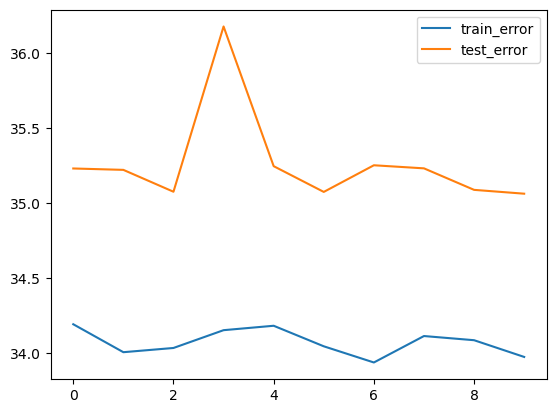

In [21]:
plt.figure()
plt.plot(train_error, label='train_error')
plt.plot(test_error, label='test_error')
plt.legend()

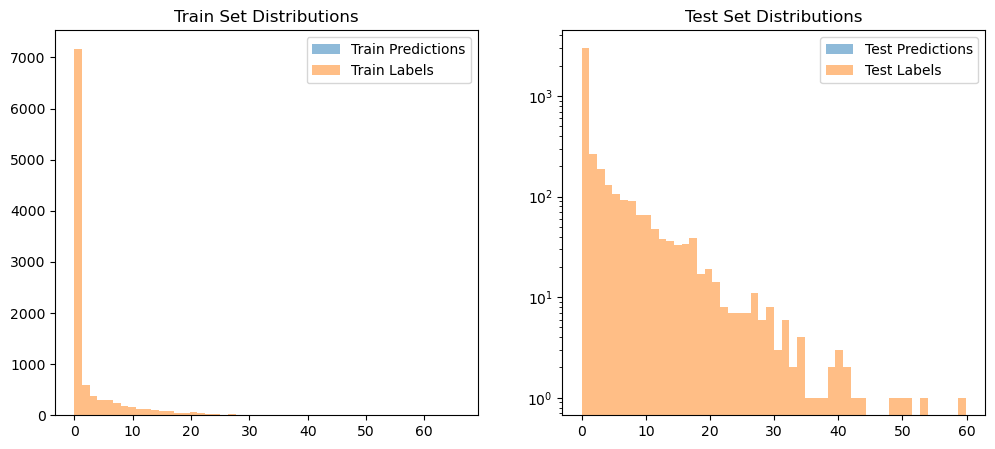

In [ ]:
import matplotlib.pyplot as plt

model.eval()

# Récupère toutes les prédictions et labels du train set
all_preds_train = []
all_labels_train = []

with torch.no_grad():
    for x, y in train_loader:
        preds = model(x).squeeze(-1)
        all_preds_train.append(preds)
        all_labels_train.append(y)

all_preds_train = torch.cat(all_preds_train).cpu().numpy()
all_labels_train = torch.cat(all_labels_train).cpu().numpy()

# Pareil pour le test set
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for x, y in test_loader:
        preds = model(x).squeeze()
        all_preds_test.append(preds)
        all_labels_test.append(y)

all_preds_test = torch.cat(all_preds_test).cpu().numpy()
all_labels_test = torch.cat(all_labels_test).cpu().numpy()

# Plot distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_preds_train, bins=50, alpha=0.5, label='Train Predictions', range=(2.65, 2.75))
plt.hist(all_labels_train, bins=50, alpha=0.5, label='Train Labels')
plt.title("Train Set Distributions")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(all_preds_test, bins=50, alpha=0.5, label='Test Predictions', range=(2.65, 2.75))
plt.hist(all_labels_test, bins=50, alpha=0.5, label='Test Labels')
plt.title("Test Set Distributions")
plt.yscale('log')
plt.legend()

plt.show()

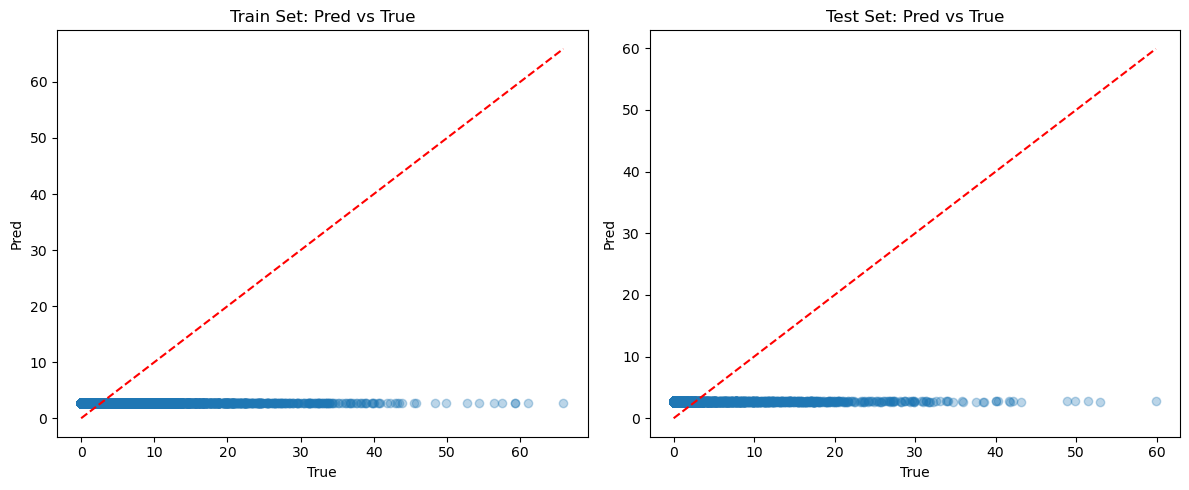

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(all_labels_train, all_preds_train, alpha=0.3)
plt.plot([all_labels_train.min(), all_labels_train.max()], 
         [all_labels_train.min(), all_labels_train.max()], 'r--')
plt.title('Train Set: Pred vs True')
plt.xlabel('True')
plt.ylabel('Pred')

plt.subplot(1, 2, 2)
plt.scatter(all_labels_test, all_preds_test, alpha=0.3)
plt.plot([all_labels_test.min(), all_labels_test.max()], 
         [all_labels_test.min(), all_labels_test.max()], 'r--')
plt.title('Test Set: Pred vs True')
plt.xlabel('True')
plt.ylabel('Pred')

plt.tight_layout()
plt.show()